In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

In [2]:
import sys
sys.path.append('/home/chenzhao/csst/simulation/csstemu/')
from CEmulator.Emulator import CEmulator
csstemu = CEmulator(verbose=True)

Loading the Bkmm emulator...
Using 129 training samples.
Loading the Bkmm_halofit emulator...
Using 129 training samples.
Loading the PkcbLin emulator...
Using 513 training samples.
Loading the XihmNL emulator...
Using 65 training samples.
Loading the PkhmNL emulator...
Using 65 training samples.


In [3]:
%%time
csstemu.set_cosmos(Omegam=0.3)
klist = np.logspace(-2, 0.9, 1000)
zlist = np.array([0.0, 1.0, 2.0, 3.0])
pkce = csstemu.get_pknl(z=zlist, k=klist, 
                        Pcb=True, lintype='Emulator', 
                        nltype='halofit')
print(pkce.shape)

(4, 1000)
CPU times: user 35.2 ms, sys: 3.05 ms, total: 38.3 ms
Wall time: 37.6 ms


In [4]:
%%time
cosmo_class = csstemu.get_cosmos_class(z=zlist, kmax=10.0, non_linear='HMCODE')
pkhm = np.zeros((len(zlist), len(klist)))
h0 = csstemu.Cosmo.h0
for iz in range(len(zlist)):
    pkhm[iz] = np.array([cosmo_class.pk_cb(z=zlist[iz], k=ik*h0)*h0*h0*h0 for ik in klist])

CPU times: user 4.11 s, sys: 20.9 ms, total: 4.13 s
Wall time: 4.22 s


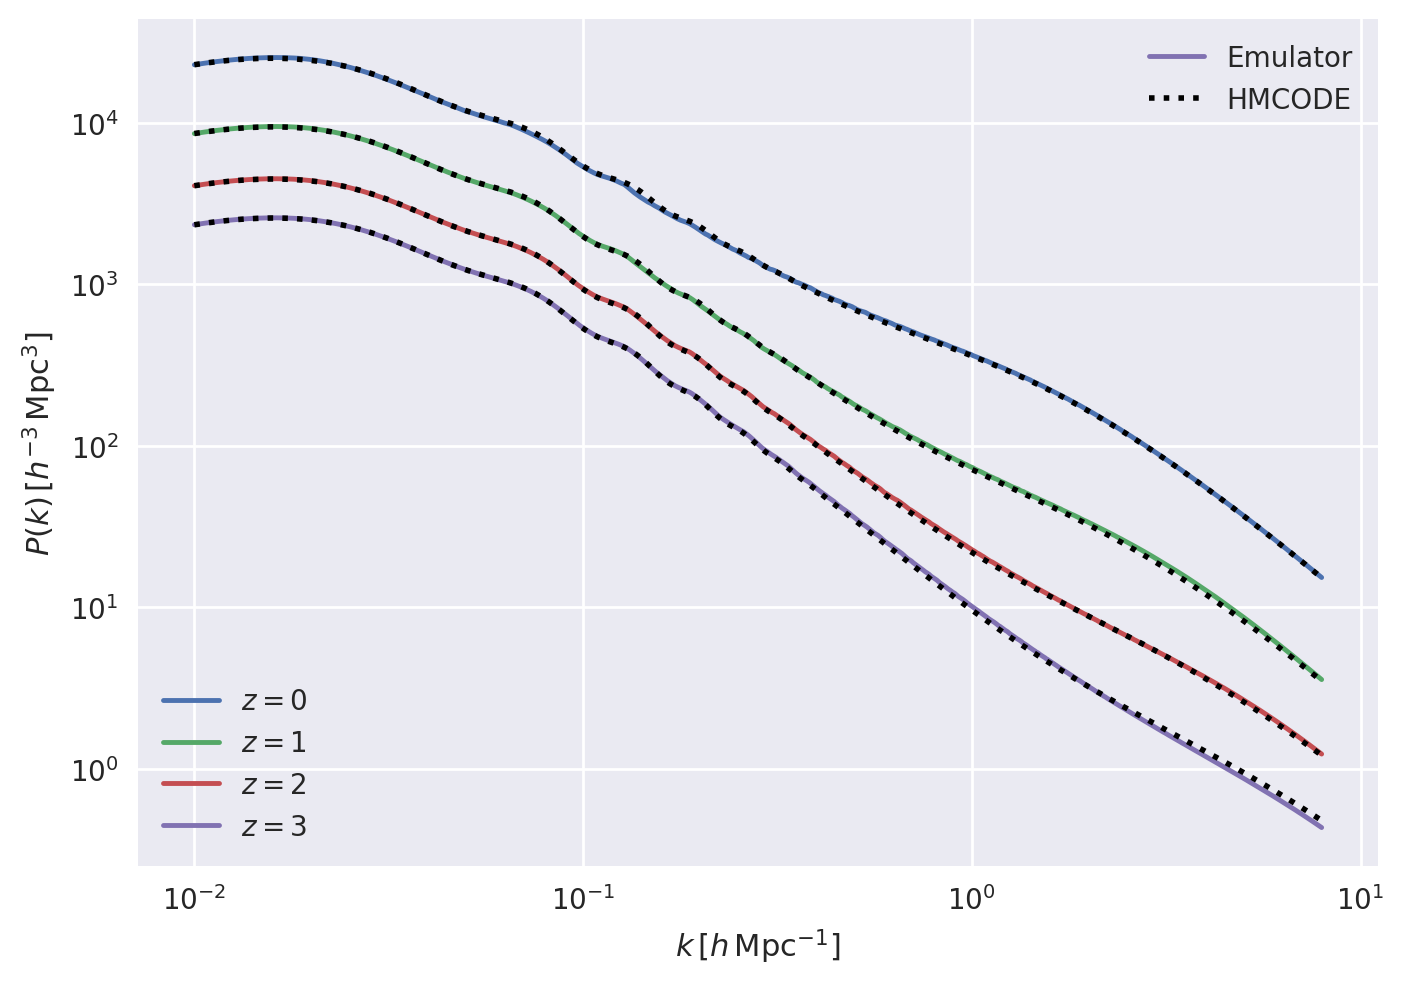

In [5]:
with plt.style.context('seaborn'):
    ax0 = plt.subplot(111)
    for iz in range(len(zlist)):
        l1, = plt.loglog(klist, pkce[iz], label=r'$z=%.0f$'%(zlist[iz]))
        l2, = plt.loglog(klist, pkhm[iz], 'k:', lw=2.0)
    leg1 = plt.legend([l1, l2], ['Emulator', 'HMCODE'], loc=0)
    leg2 = plt.legend(loc=3)
    ax0.add_artist(leg1)
    plt.xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
    plt.ylabel(r'$P(k)\, [h^{-3}\,{\rm Mpc}^3]$')